#### Load Dataset

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [2]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset
dataset = load_dataset("ccdv/pubmed-summarization")

combined_dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])

def has_non_empty_fields(example):
    return (
        example['article'] is not None and
        example['abstract'] is not None and
        isinstance(example['article'], str) and
        isinstance(example['abstract'], str) and
        example['article'].strip() != "" and
        example['abstract'].strip() != ""
    )

clean_dataset = combined_dataset.filter(has_non_empty_fields)

clean_dataset = clean_dataset.shuffle(seed=42)

def filter_by_length(example):
    return len(example['article'].split()) <= 2500 and len(example['abstract'].split()) <= 250

filtered_dataset = clean_dataset.filter(filter_by_length)

filtered_dataset = filtered_dataset.shuffle(seed=42)

if len(filtered_dataset) < 11500:
    raise ValueError(f"Not enough samples after filtering: {len(filtered_dataset)} found.")

train_dataset = filtered_dataset.select(range(9000))
validation_dataset = filtered_dataset.select(range(9000, 10000))
test_dataset = filtered_dataset.select(range(10000, 10300))

# 8. Create DatasetDict with splits
df = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset,
})

print(df)


README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/207M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

Filter:   0%|          | 0/133215 [00:00<?, ? examples/s]

Filter:   0%|          | 0/130397 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 9000
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 300
    })
})


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

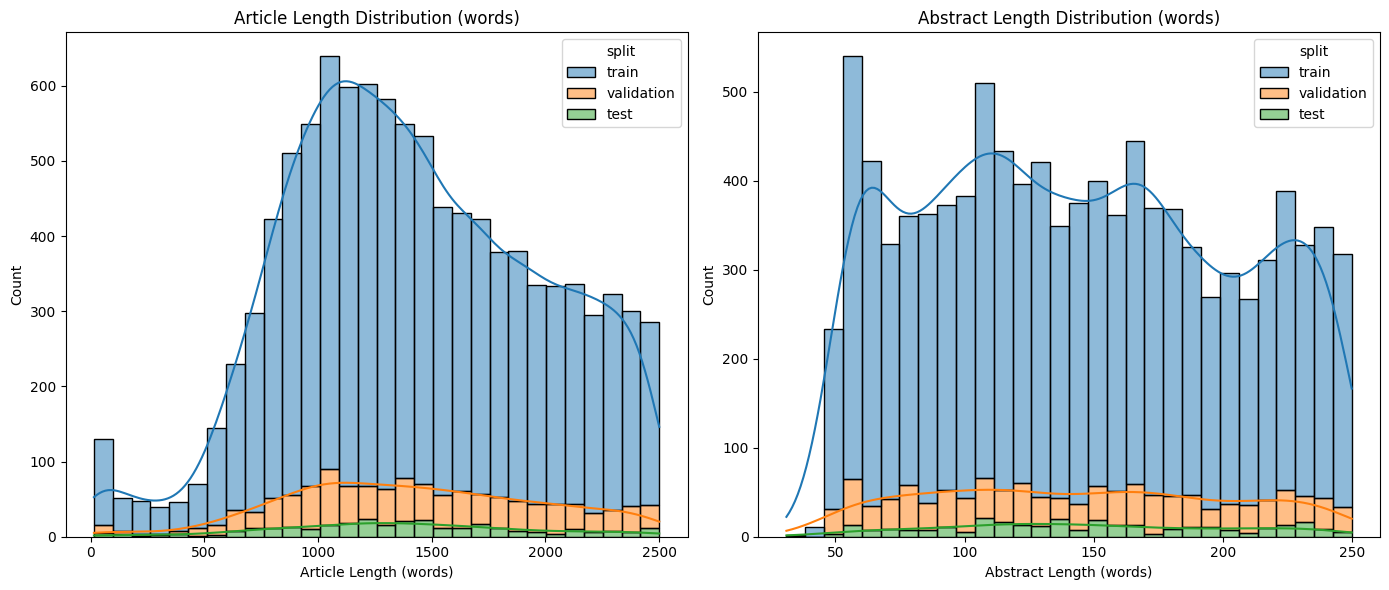

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
lengths = {'split': [], 'article_len': [], 'abstract_len': []}

for split_name, dataset in df.items():
    for example in dataset:
        article_len = len(example['article'].split())
        abstract_len = len(example['abstract'].split())
        lengths['split'].append(split_name)
        lengths['article_len'].append(article_len)
        lengths['abstract_len'].append(abstract_len)

# Convert to DataFrame
df_lengths = pd.DataFrame(lengths)

# Plot distributions
plt.figure(figsize=(14,6))

# Article length distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df_lengths, x='article_len', hue='split', bins=30, kde=True, multiple='stack')
plt.title('Article Length Distribution (words)')
plt.xlabel('Article Length (words)')

# Abstract length distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df_lengths, x='abstract_len', hue='split', bins=30, kde=True, multiple='stack')
plt.title('Abstract Length Distribution (words)')
plt.xlabel('Abstract Length (words)')

plt.tight_layout()
plt.savefig('length_distributions.pdf')
plt.show()


## 2. FINE - TUNING MODEL

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import TrainingArguments, Trainer
from transformers import AutoConfig, EarlyStoppingCallback

2025-06-17 20:54:10.670350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750193650.893891      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750193650.961485      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load config and modify dropout
config = AutoConfig.from_pretrained("facebook/bart-base")
config.attention_dropout = 0.3
config.activation_dropout = 0.3
config.dropout = 0.3
config.classifier_dropout = 0.3

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

#### tokenization

In [8]:
def preprocess_function(batch):
    source = batch['article']
    target = batch['abstract']
    source_ids = tokenizer(source, truncation=True, padding="max_length", max_length=1024)
    target_ids = tokenizer(target, truncation=True, padding="max_length", max_length=256)

    # Replace pad token id with -100 for labels to ignore padding in loss computation
    labels = target_ids["input_ids"]
    labels = [[(label if label != tokenizer.pad_token_id else -100) for label in labels_example] for labels_example in labels]

    return {
        "input_ids": source_ids["input_ids"],
        "attention_mask": source_ids["attention_mask"],
        "labels": labels
    }

df_source = df.map(preprocess_function, batched=True)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Define training arguments

In [9]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/model_output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=20,
    learning_rate=3e-5,

    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    weight_decay=0.01,
    max_grad_norm=1.0,
    
    remove_unused_columns=False,
    logging_steps=50,
    report_to="none",
    
    save_strategy="epoch",
    logging_dir="/kaggle/working/logs",
    eval_strategy="epoch",
    logging_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

#### Create Trainer object

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_source["train"],
    eval_dataset=df_source["validation"],
    compute_metrics=None,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [11]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.415700,2.291502
2,2.380400,2.211984
3,2.133900,2.151001
4,2.143000,2.127221
5,1.978500,2.111104
6,1.834000,2.123980
7,1.704500,2.128280
8,1.719600,2.148199


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tens

TrainOutput(global_step=18000, training_loss=2.0998971095614962, metrics={'train_runtime': 10517.1816, 'train_samples_per_second': 17.115, 'train_steps_per_second': 4.279, 'total_flos': 4.390102499328e+16, 'train_loss': 2.0998971095614962, 'epoch': 8.0})

In [12]:
print(trainer.state.log_history)


[{'loss': 4.1382, 'grad_norm': 14.328018188476562, 'learning_rate': 3.266666666666667e-07, 'epoch': 0.022222222222222223, 'step': 50}, {'loss': 3.7822, 'grad_norm': 9.077718734741211, 'learning_rate': 6.599999999999999e-07, 'epoch': 0.044444444444444446, 'step': 100}, {'loss': 3.6034, 'grad_norm': 9.831472396850586, 'learning_rate': 9.933333333333333e-07, 'epoch': 0.06666666666666667, 'step': 150}, {'loss': 3.4917, 'grad_norm': 7.652923107147217, 'learning_rate': 1.3266666666666667e-06, 'epoch': 0.08888888888888889, 'step': 200}, {'loss': 3.2442, 'grad_norm': 12.533951759338379, 'learning_rate': 1.66e-06, 'epoch': 0.1111111111111111, 'step': 250}, {'loss': 3.4037, 'grad_norm': 6.973758697509766, 'learning_rate': 1.9933333333333334e-06, 'epoch': 0.13333333333333333, 'step': 300}, {'loss': 3.1769, 'grad_norm': 7.388058662414551, 'learning_rate': 2.3266666666666667e-06, 'epoch': 0.15555555555555556, 'step': 350}, {'loss': 3.127, 'grad_norm': 7.706436634063721, 'learning_rate': 2.660000000

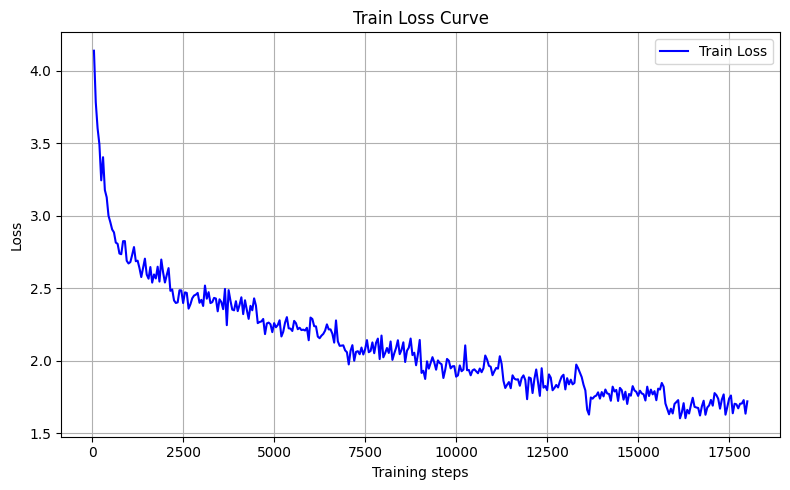

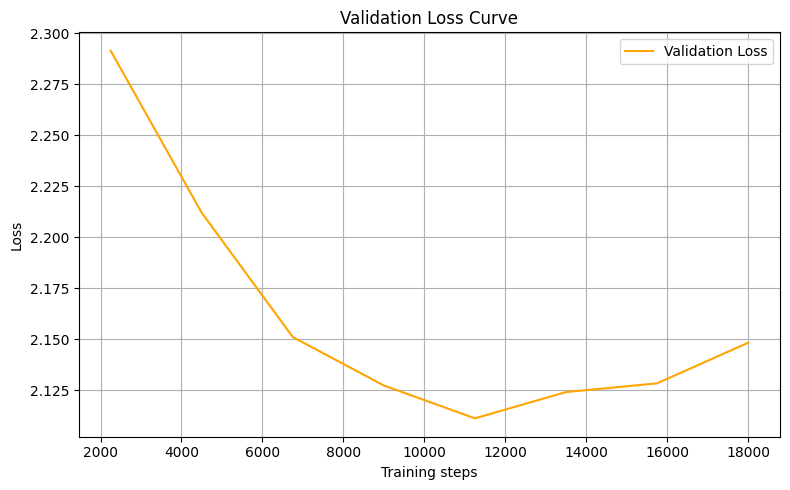

In [13]:
import matplotlib.pyplot as plt

# Get log history from trainer
log_history = trainer.state.log_history

# Extract train loss
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
train_steps = [entry["step"] for entry in log_history if "loss" in entry]

# Extract validation loss
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
eval_steps = [entry["step"] for entry in log_history if "eval_loss" in entry]

# --- Save train loss curve ---
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, label="Train Loss", color="blue")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Train Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_loss_curve.pdf")
plt.show()
plt.close()

# --- Save validation loss curve ---
plt.figure(figsize=(8, 5))
plt.plot(eval_steps, eval_loss, label="Validation Loss", color="orange")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("validation_loss_curve.pdf")
plt.show()
plt.close()


#### Evaluate the model

In [14]:
eval_results = trainer.evaluate()

print(eval_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 2.1111035346984863, 'eval_runtime': 44.4269, 'eval_samples_per_second': 22.509, 'eval_steps_per_second': 5.627, 'epoch': 8.0}


#### SAVING THE MODEL

In [15]:
model.save_pretrained("/kaggle/working/model_directory")
tokenizer.save_pretrained("/kaggle/working/model_directory")

('/kaggle/working/model_directory/tokenizer_config.json',
 '/kaggle/working/model_directory/special_tokens_map.json',
 '/kaggle/working/model_directory/vocab.json',
 '/kaggle/working/model_directory/merges.txt',
 '/kaggle/working/model_directory/added_tokens.json',
 '/kaggle/working/model_directory/tokenizer.json')

# Evaluation

In [16]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.9 MB/s eta 0:00:00


In [17]:
pip install bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [18]:
!pip install fpdf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=cc5d4f158ad3286e6203bb20e602a7dad58fcd5298ffb384c1d435e511ed9848
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [19]:
pip install -U evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=532666475c372eac0e581046d1c20d197aeb76697987a7f2682cf8fdf836365b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install reportlab

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install evaluate nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [23]:
import evaluate

bertscore = evaluate.load("bertscore")

In [24]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from evaluate import load
from bert_score import score
import pandas as pd
from fpdf import FPDF

In [25]:
# Load model & tokenizer (adjust paths accordingly)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/model_directory")
model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/model_directory")
model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [26]:
# Directory to save outputs
output_dir = "/kaggle/working/eval_outputs"
os.makedirs(output_dir, exist_ok=True)

In [27]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from bert_score import score as bertscore_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from nltk.tokenize import word_tokenize
from fpdf import FPDF
import nltk
import transformers

# Suppress RoBERTa warning
transformers.logging.set_verbosity_error()

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Set up output directory
output_dir = "/kaggle/working/eval_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load model and tokenizer
model_dir = "/kaggle/working/model_directory"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
model.eval()

# Define generate_summary function
def generate_summary(text):
    inputs = tokenizer(text, max_length=1024, truncation=True, return_tensors="pt")
    with torch.no_grad():
        summary_ids = model.generate(
            inputs["input_ids"],
            max_length=250,
            min_length=40,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Define compute_metrics_batch function
def compute_metrics_batch(hypotheses, references):
    # BERTScore
    P, R, F1 = bertscore_score(hypotheses, references, lang="en", verbose=False)
    avg_bert = (P.mean().item(), R.mean().item(), F1.mean().item())

    # ROUGE scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores, rouge2_scores, rougel_scores = [], [], []
    for hyp, ref in zip(hypotheses, references):
        scores = rouge.score(ref, hyp)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougel_scores.append(scores['rougeL'].fmeasure)
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougel = sum(rougel_scores) / len(rougel_scores)

    # BLEU and METEOR
    smoothing = SmoothingFunction().method1
    bleu_scores = []
    meteor_scores = []
    for hyp, ref in zip(hypotheses, references):
        ref_tokens = word_tokenize(ref)
        hyp_tokens = word_tokenize(hyp)
        bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)
        meteor = single_meteor_score(ref_tokens, hyp_tokens)
        meteor_scores.append(meteor)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    return {
        "bert_precision": avg_bert[0],
        "bert_recall": avg_bert[1],
        "bert_f1": avg_bert[2],
        "rouge1": avg_rouge1,
        "rouge2": avg_rouge2,
        "rougel": avg_rougel,
        "bleu": avg_bleu,
        "meteor": avg_meteor,
    }

# Corrected save_detailed_report_pdf function
def save_detailed_report_pdf(data_list, pdf_path, tokenizer, model):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    pdf.set_font("Arial", "B", 14)
    pdf.cell(0, 10, "Summary Report with Metrics", ln=True, align="C")
    pdf.ln(10)

    abstracts = []  # References
    summaries = []  # Hypotheses

    # Generate summaries for entire test data
    for idx, example in enumerate(data_list):
        article = example["article"]
        abstract = example["abstract"]
        summary = generate_summary(article)

        abstracts.append(abstract)
        summaries.append(summary)

        # Add to PDF
        pdf.set_font("Arial", "B", 12)
        pdf.multi_cell(0, 8, f"Example {idx + 1}:", align="L")

        pdf.set_font("Arial", "B", 11)
        pdf.cell(0, 6, "Abstract:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 6, abstract)
        pdf.ln(2)

        pdf.set_font("Arial", "B", 11)
        pdf.cell(0, 6, "Generated Summary:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 6, summary)
        pdf.ln(4)

    # Compute metrics
    metrics = compute_metrics_batch(summaries, abstracts)

    # Add metrics to PDF
    pdf.add_page()
    pdf.set_font("Arial", "B", 14)
    pdf.cell(0, 10, "Overall Metrics Summary", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Arial", "B", 12)
    metrics_names = [
        "BERT Precision", "BERT Recall", "BERT F1",
        "ROUGE-1", "ROUGE-2", "ROUGE-L",
        "BLEU", "METEOR"
    ]
    metrics_values = [
        metrics["bert_precision"], metrics["bert_recall"], metrics["bert_f1"],
        metrics["rouge1"], metrics["rouge2"], metrics["rougel"],
        metrics["bleu"], metrics["meteor"]
    ]

    pdf.set_font("Arial", "", 11)
    for name, val in zip(metrics_names, metrics_values):
        pdf.cell(0, 8, f"{name}: {val:.4f}", ln=True)

    pdf.ln(10)
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Overall Metrics Table", ln=True, align="C")

    # Fix: Use pdf.w - pdf.l_margin - pdf.r_margin instead of pdf.epw
    col_width = (pdf.w - pdf.l_margin - pdf.r_margin) / len(metrics_names)
    pdf.set_font("Arial", "B", 10)
    for name in metrics_names:
        pdf.cell(col_width, 8, name, border=1, align="C")
    pdf.ln()

    pdf.set_font("Arial", "", 10)
    for val in metrics_values:
        pdf.cell(col_width, 8, f"{val:.4f}", border=1, align="C")
    pdf.ln()

    pdf.output(pdf_path)
    print(f"Saved detailed PDF report to {pdf_path}")

    # Save hypotheses and references to CSV
    results_df = pd.DataFrame({"Hypothesis": summaries, "Reference": abstracts})
    csv_path = os.path.join(os.path.dirname(pdf_path), "hypotheses_references.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"Saved hypotheses and references to {csv_path}")

    return summaries, abstracts, metrics

# Process entire test data
data_list = [item for item in df["test"]]
hypotheses, references, metrics = save_detailed_report_pdf(
    data_list, os.path.join(output_dir, "summary_report.pdf"), tokenizer, model
)

# Print metrics
print("Evaluation Metrics for Entire Test Data:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Save metrics to a separate file
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(output_dir, "evaluation_metrics.csv"), index=False)
print(f"Saved metrics to {os.path.join(output_dir, 'evaluation_metrics.csv')}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Saved detailed PDF report to /kaggle/working/eval_outputs/summary_report.pdf
Saved hypotheses and references to /kaggle/working/eval_outputs/hypotheses_references.csv
Evaluation Metrics for Entire Test Data:
bert_precision: 0.8597
bert_recall: 0.8609
bert_f1: 0.8601
rouge1: 0.4123
rouge2: 0.1781
rougel: 0.2617
bleu: 0.1223
meteor: 0.2924
Saved metrics to /kaggle/working/eval_outputs/evaluation_metrics.csv
